In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter

# By setting a random seed, we ensure that the sequence of random numbers generated during training,
                                                  # remains the same across different runs of the code.
# keras.utils.set_random_seed(111)

2025-04-15 07:37:28.509920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744702648.688906      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744702648.740181      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMAGES_PATH = "/input/flickr8k/Images" # Path to the images
CAPTIONS_PATH = "/input/flickr8k/captions.txt" # Path to the caption
IMAGE_SIZE = (299, 299) # Preferred image dimensions for efficientnet
SEQ_LENGTH = 25 # max length allowed for any sequence
VOCAB_SIZE = 8898 # Vocab size
EMBED_DIM = 512 # Dim for the img  and token embeddings
FF_DIM = 512 ## Dim of the feed-forward network
BATCH_SIZE = 512
EPOCHS = 30 # max epochs

In [ ]:
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:] #skip header
        caption_mapping = {} # {img_file_name: [captions]}
        text_data = [] # captions vovcab 
        images_to_skip = set() # short or invalid captioned images

        for line in caption_data:
            line = line.rstrip("\n")
            img_name, caption = line.split(",", 1) # split img_name and caption
            img_name = os.path.join(IMAGES_PATH, img_name.strip()) # get full img path
            tokens = caption.strip().split()
            ## Drop captions that are too short or too long
            if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                caption = "<start> " + caption.strip() + " <end>" # Apending start and an end token for the captions
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

def train_val_split(caption_data, validation_size=0.2, test_size=0.05, shuffle=True):
    """Create train val test split"""
    all_images = list(caption_data.keys())
    
    ## shuffle images
    if shuffle:
        np.random.shuffle(all_images) 
    
    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)
    
    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}
    return training_data, validation_data, test_data

# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

Total number of samples: 7643
----> Number of training samples: 6114
----> Number of validation samples: 1452
----> Number of test samples: 77


## Defining **the vectorizer** with custom standardization and image augmentation

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890" # drop alphanumeric/symbols
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer text -> int seq for model
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE, # token upper limt
    output_mode="int", # op token idx as int
    output_sequence_length=SEQ_LENGTH, # pad/truncate captions to seq_length
    standardize=custom_standardization) # remove alphanumerics and lower case


vectorization.adapt(text_data) # build vocab using text+data

# Data augmentation for img
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.2),
                                       layers.RandomContrast(0.3)])

# fix compatibitibily issues with non tf pipelines
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))

I0000 00:00:1744702675.283189      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Visualizing some of the images along with the corresponding captions

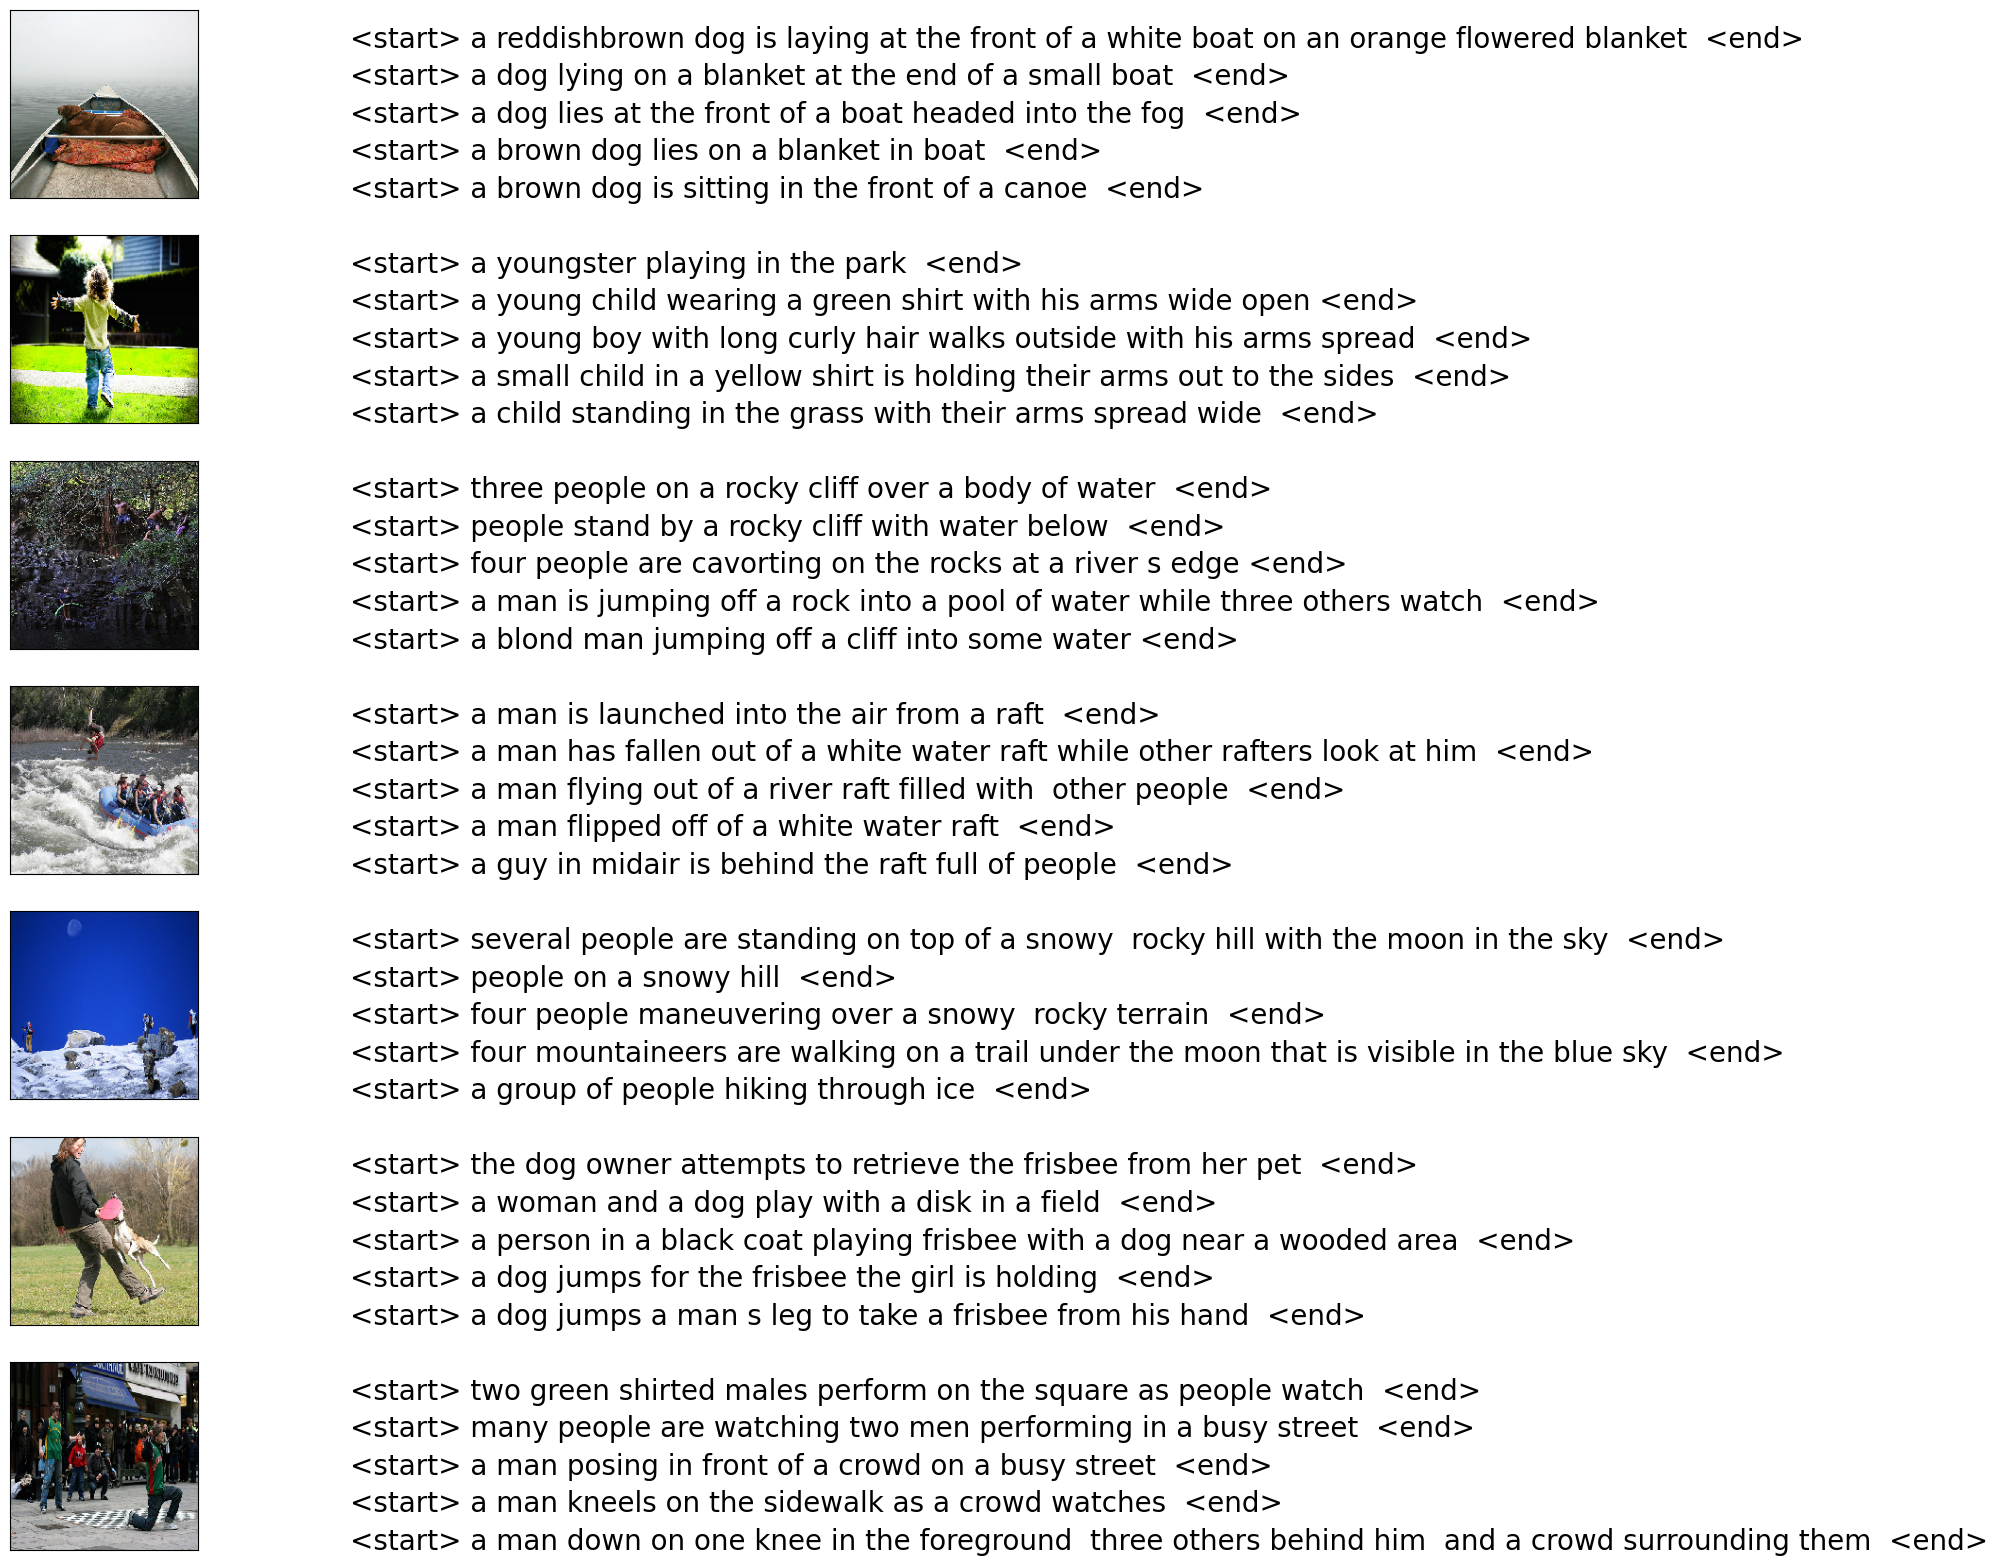

In [5]:
def visualaization(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[100:100+num_of_images]:
        captions = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], data[filename]))
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(train_data, 7)

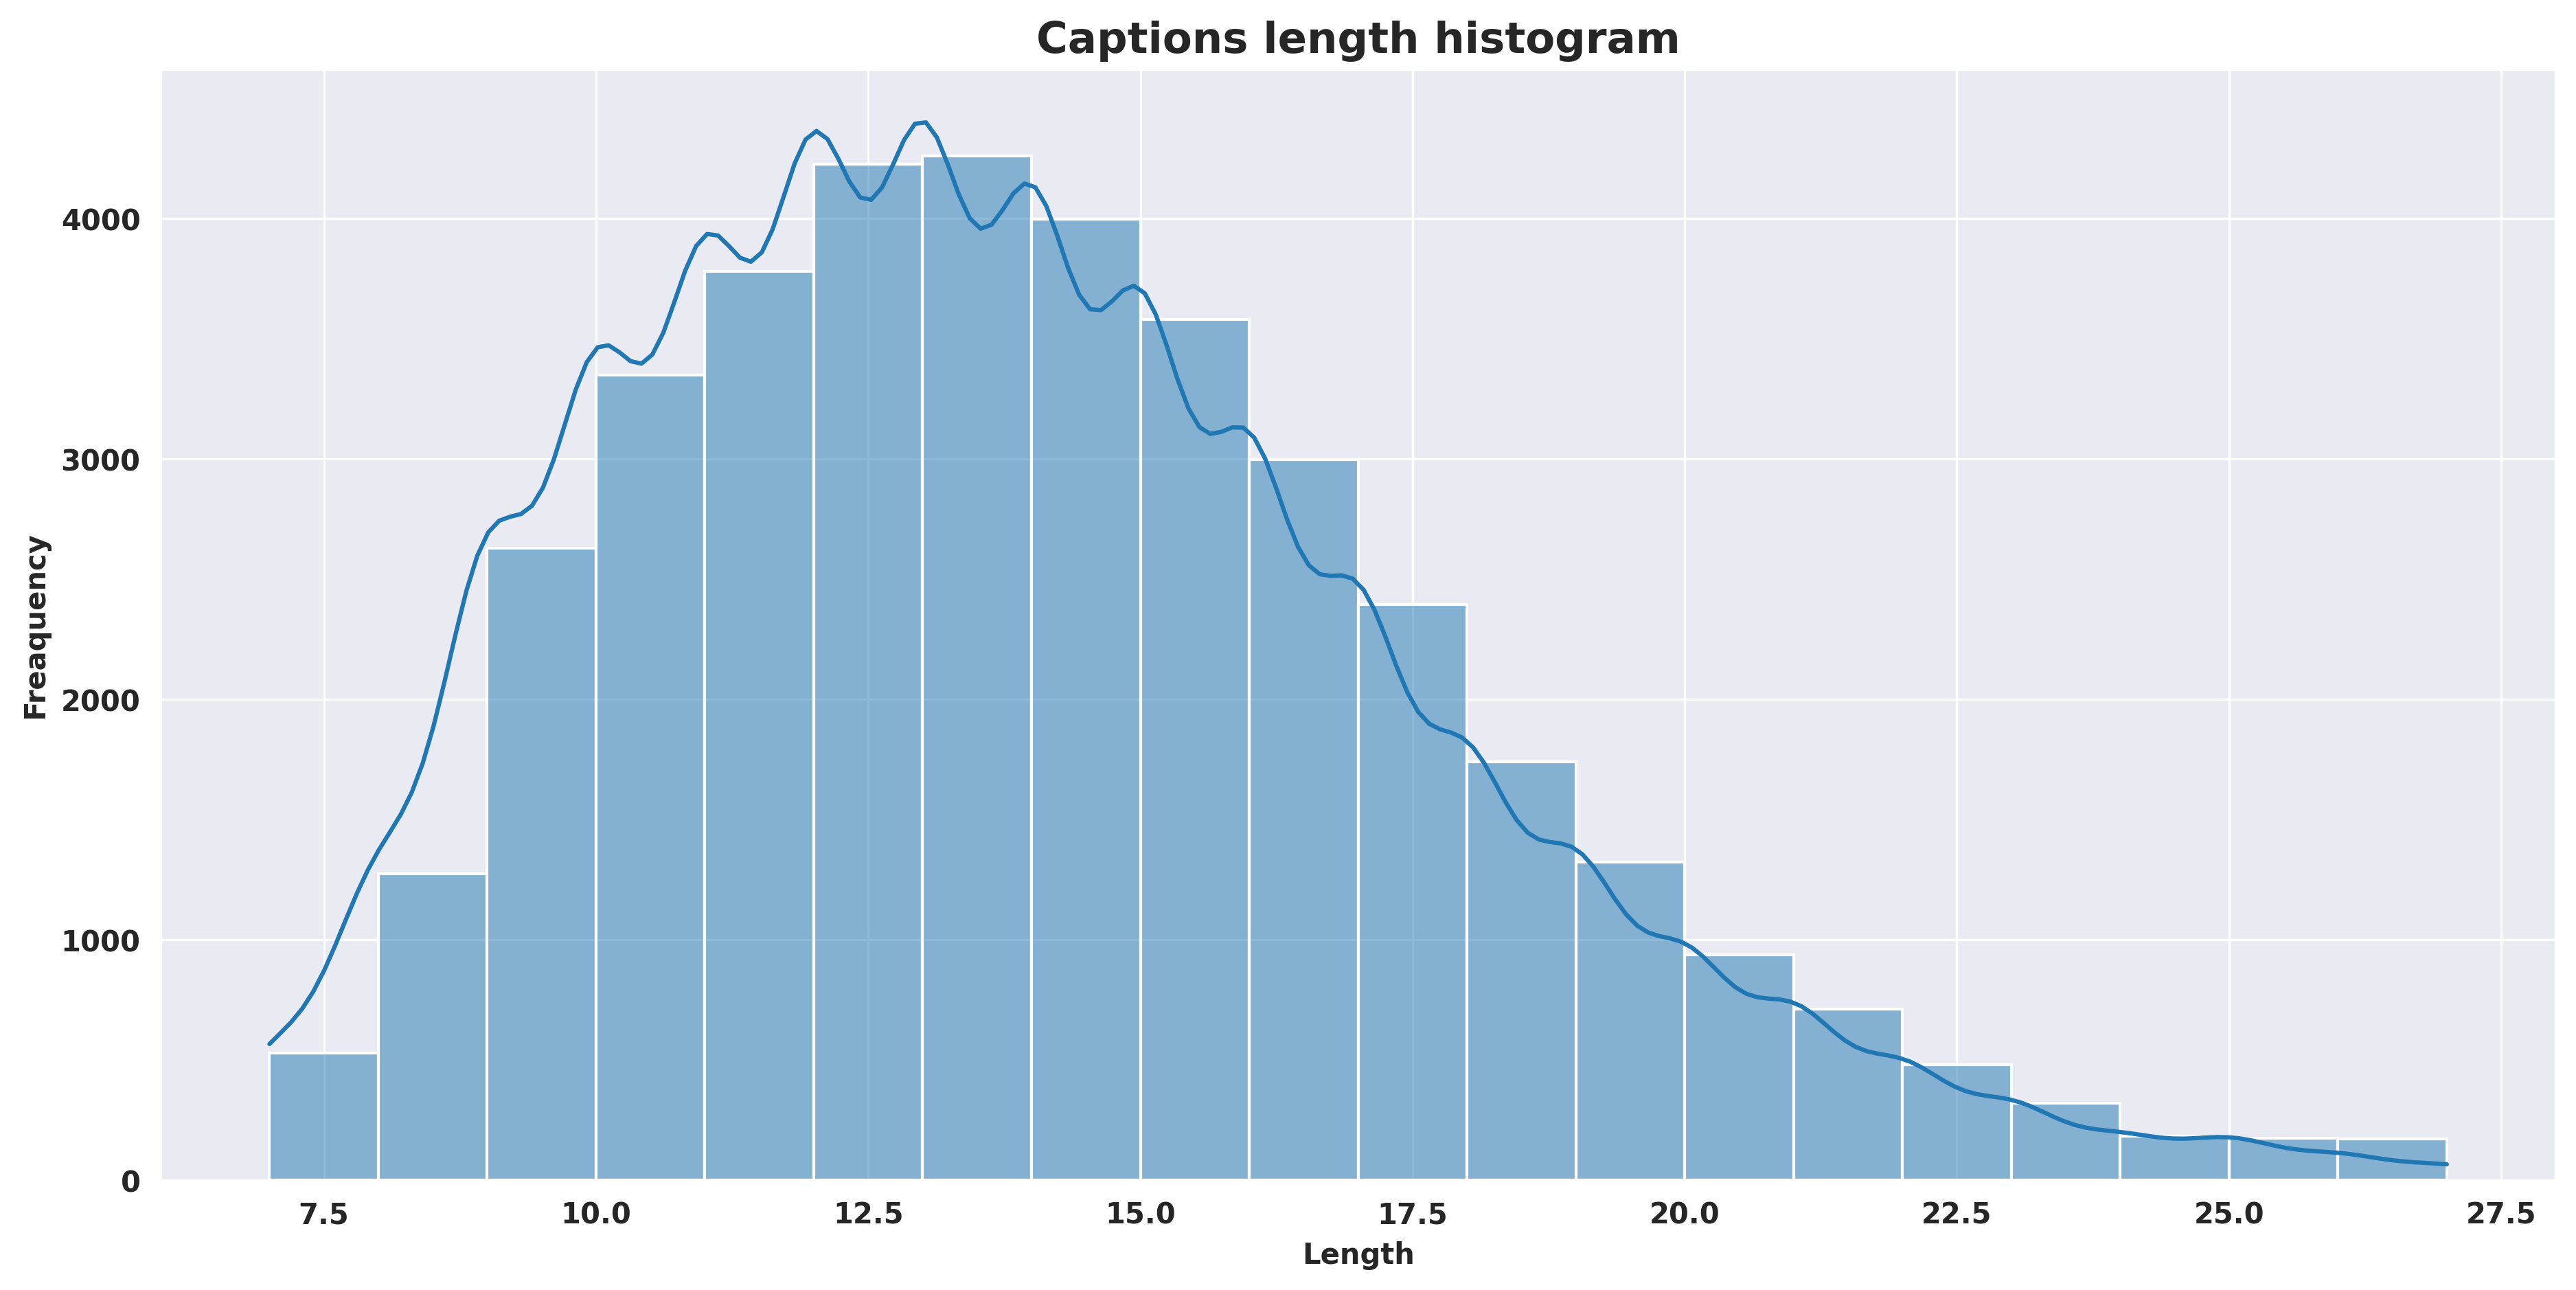

In [6]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(text_data)

In [28]:
import numpy as np
import tensorflow as tf

# -----------------------------
# UPDATED MASK LOADER FUNCTION:
# -----------------------------
def load_npy_mask(mask_path):
    # Check if mask_path is a byte string; if so, decode it.
    if isinstance(mask_path, bytes):
        mask_path = mask_path.decode("utf-8")
    data = np.load(mask_path, allow_pickle=True).item()
    # Extract the masks; expected shape is (3, H, W)
    masks = data['masks']
    # Combine the 3 masks using a union.
    # This will result in a mask which is True where ANY of the 3 masks is active.
    combined_mask = np.any(masks, axis=0).astype(np.float32)
    return combined_mask

# -----------------------------
# MASK DECODER & RESIZE FUNCTION:
# -----------------------------
def decode_and_resize_mask(mask_path, target_size):
    # Use tf.numpy_function to load the numpy mask file with our updated function.
    mask = tf.numpy_function(load_npy_mask, [mask_path], tf.float32)
    # Set the shape if possible; if you know the original mask size, specify it here (e.g. [300,300]).
    mask.set_shape([None, None])
    # Add a channel dimension: (H, W) -> (H, W, 1)
    mask = tf.expand_dims(mask, axis=-1)
    # Resize to the target size (e.g., for feature map shape, like (10, 10))
    mask = tf.image.resize(mask, target_size)
    # Binarize the mask (any value > 0.5 becomes 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    return mask

# -----------------------------
# SAMPLE USAGE IN DATASET PIPELINE:
# -----------------------------
IMAGE_SIZE = (300, 300)       # Image input size
FEATURE_MAP_SIZE = (10, 10)   # Target size for the mask (to match CNN feature map spatial dimensions)

def decode_and_resize_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

MASK_DIR = "/kaggle/input/sam-feat/sam_features_f"

def process_sample(img_path, caption):
    # Extract image basename (e.g. '1000268201_693b08cb0e.jpg' → '1000268201_693b08cb0e')
    filename = tf.strings.regex_replace(tf.strings.split(img_path, '/')[-1], '\\.jpg$', '')
    # Construct full mask path
    mask_path = tf.strings.join([MASK_DIR, "/", filename, ".npy"])
    
    # Process the image
    img = decode_and_resize_img(img_path)
    # Load and resize the mask
    mask = decode_and_resize_mask(mask_path, FEATURE_MAP_SIZE)
    # Vectorize the caption
    cap_vec = vectorization(caption)
    
    return (img, mask), cap_vec

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example usage:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import efficientnet.tfkeras as efficientnet

# ---- Configuration ----
IMAGE_SIZE = (300, 300)         # Input image size for images
FEATURE_MAP_SIZE = (10, 10)     # Target mask size (applied on feature maps)
EMBED_DIM = 512                 # Desired embedding dimension (set as needed)
FF_DIM = 1024                   # Transformer feed-forward dimension
SEQ_LENGTH = 20                 # Maximum caption sequence length
VOCAB_SIZE = 10000              # Vocabulary size for captions
BATCH_SIZE = 32                 # Batch size
image_augmentation = None       # Your image augmentation function (or None)

# ---- CNN Model (Feature Extractor) ----
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,  # Remove classification head
        weights="imagenet"
    )
    base_model.trainable = False
    # EfficientNetB0 with input (300,300,3) produces a feature map ~ (None, 10, 10, channels)
    cnn_out = base_model.output
    # Adjust channels to EMBED_DIM via 1×1 convolution:
    cnn_out = layers.Conv2D(EMBED_DIM, (1, 1), activation="relu")(cnn_out)
    cnn_model = keras.models.Model(base_model.input, cnn_out)
    return cnn_model

# ---- Transformer Encoder Block ----
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # inputs shape: (batch, num_patches, embed_dim)
        x = self.layernorm_1(inputs)
        x = self.dense_1(x)
        attn_out = self.attention_1(query=x,
                                    value=x,
                                    key=x,
                                    attention_mask=None,
                                    training=training)
        out_1 = self.layernorm_2(x + attn_out)
        return out_1

# ---- Positional Embedding Layer ----
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        # inputs shape: (batch, sequence_length)
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# ---- Transformer Decoder Block ----
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Positional embedding for captions
        self.embedding = PositionalEmbedding(sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        # inputs: caption tokens, shape (batch, seq_len)
        x = self.embedding(inputs)  # (batch, seq_len, embed_dim)
        causal_mask = self.get_causal_attention_mask(x)

        # Combine padding mask (if provided) with causal mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        else:
            combined_mask = causal_mask

        attention_output_1 = self.attention_1(query=x,
                                              value=x,
                                              key=x,
                                              attention_mask=combined_mask,
                                              training=training)
        out_1 = self.layernorm_1(x + attention_output_1)

        # Cross attention with image features (encoder outputs)
        cross_attention_output_2 = self.cross_attention_2(query=out_1,
                                                          value=encoder_outputs,
                                                          key=encoder_outputs,
                                                          attention_mask=padding_mask if mask is not None else None,
                                                          training=training)
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)

        preds = self.out(ffn_out)
        return preds

    # Causal mask to block future tokens
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, sequence_length, sequence_length))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

# ---- Image Captioning Model ----
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")

        print()
        print(f'CNN input shape: {cnn_model.input_shape}')
        print(f'CNN output shape: {cnn_model.output_shape}', end='\n'*2)
        flattened = cnn_model.output_shape[1] * cnn_model.output_shape[2]
        print(f'Encoder input ---> Dense layer shape: (None, {flattened}, {EMBED_DIM})')
        print(f'Encoder output shape: (None, {flattened}, {EMBED_DIM})', end='\n'*2)
        print(f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH-1}) ---> (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder input 2 (Embedded image features) shape: (None, {flattened}, {EMBED_DIM})')
        print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH-1}, {VOCAB_SIZE})')

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img, mask, batch_seq, training=True):
        # 1. Extract CNN features: shape (batch, 10, 10, EMBED_DIM)
        cnn_features = self.cnn_model(img, training=training)
        # 2. Apply SAM mask element-wise (mask shape: (batch, 10, 10, 1))
        masked_features = cnn_features * mask
        # 3. Reshape to (batch, 10*10, EMBED_DIM) for the transformer encoder; force last dimension as EMBED_DIM.
        batch_size = tf.shape(masked_features)[0]
        H = tf.shape(masked_features)[1]
        W = tf.shape(masked_features)[2]
        reshaped_features = tf.reshape(masked_features, [batch_size, H * W, EMBED_DIM])
        
        # 4. Pass the reshaped features through the transformer encoder.
        encoder_out = self.encoder(reshaped_features, training=training)
        
        # 5. Prepare captions: input tokens (all except last) and target tokens (all except first)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        caption_mask = tf.math.not_equal(batch_seq_true, 0)
        
        # 6. Decode the caption using the transformer decoder.
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=caption_mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, caption_mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, caption_mask)
        return loss, acc

    def train_step(self, batch_data):
        # batch_data is ((batch_img, batch_mask), batch_seq)
        (batch_img, batch_mask), batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(batch_img, batch_mask, batch_seq[:, i, :], training=True)
                batch_loss += loss
                batch_acc += acc

            train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        (batch_img, batch_mask), batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(batch_img, batch_mask, batch_seq[:, i, :], training=False)
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

# ---- Build the Model ----
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)


CNN input shape: (None, 300, 300, 3)
CNN output shape: (None, 10, 10, 512)

Encoder input ---> Dense layer shape: (None, 100, 512)
Encoder output shape: (None, 100, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 19) ---> (None, 19, 512)
Decoder input 2 (Embedded image features) shape: (None, 100, 512)
Decoder output (MH Cross-Attention) shape: (None, 19, 512)
Decoder prediction (Dense layer) shape: (None, 19, 10000)


In [30]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation loss for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)
    
# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/30


I0000 00:00:1744704421.512650      91 service.cc:148] XLA service 0x7958680034b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744704421.513433      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1744704429.911495      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704430.797311      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704431.681239      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_2/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704432.564169      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_3/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Ass

191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - acc: 0.1646 - loss: 32.6219

W0000 00:00:1744704562.722152      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704563.381548      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704564.039757      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_2/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704564.695044      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_3/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704565.345655      91 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_4/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - acc: 0.1651 - loss: 32.5853

W0000 00:00:1744704636.973700      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704637.026403      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704637.079304      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_2/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704637.132392      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_3/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704637.185004      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossentropy_4/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1744704658.692818      88 assert_op.cc:38] Ignoring Assert operator sparse_categorical_crossent

192/192 ━━━━━━━━━━━━━━━━━━━━ 355s 893ms/step - acc: 0.1655 - loss: 32.5491 - val_acc: 0.3338 - val_loss: 19.1650
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 370ms/step - acc: 0.3376 - loss: 18.7145 - val_acc: 0.3578 - val_loss: 17.2817
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 367ms/step - acc: 0.3660 - loss: 16.8135 - val_acc: 0.3729 - val_loss: 16.4632
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 366ms/step - acc: 0.3835 - loss: 15.7342 - val_acc: 0.3776 - val_loss: 16.1126
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 371ms/step - acc: 0.3988 - loss: 14.9663 - val_acc: 0.3848 - val_loss: 15.7017
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 369ms/step - acc: 0.4121 - loss: 14.3037 - val_acc: 0.3884 - val_loss: 15.6571
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 66s 341ms/step - acc: 0.4242 - loss: 13.7426 - val_acc: 0.3927 - val_loss: 15.6303
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 72s 373ms/step - acc: 0.4363 - loss: 13.2248 - val_acc: 0.3903 - val_loss: 15.5765
Epoch 9/30
192/192 ━━━━━━━

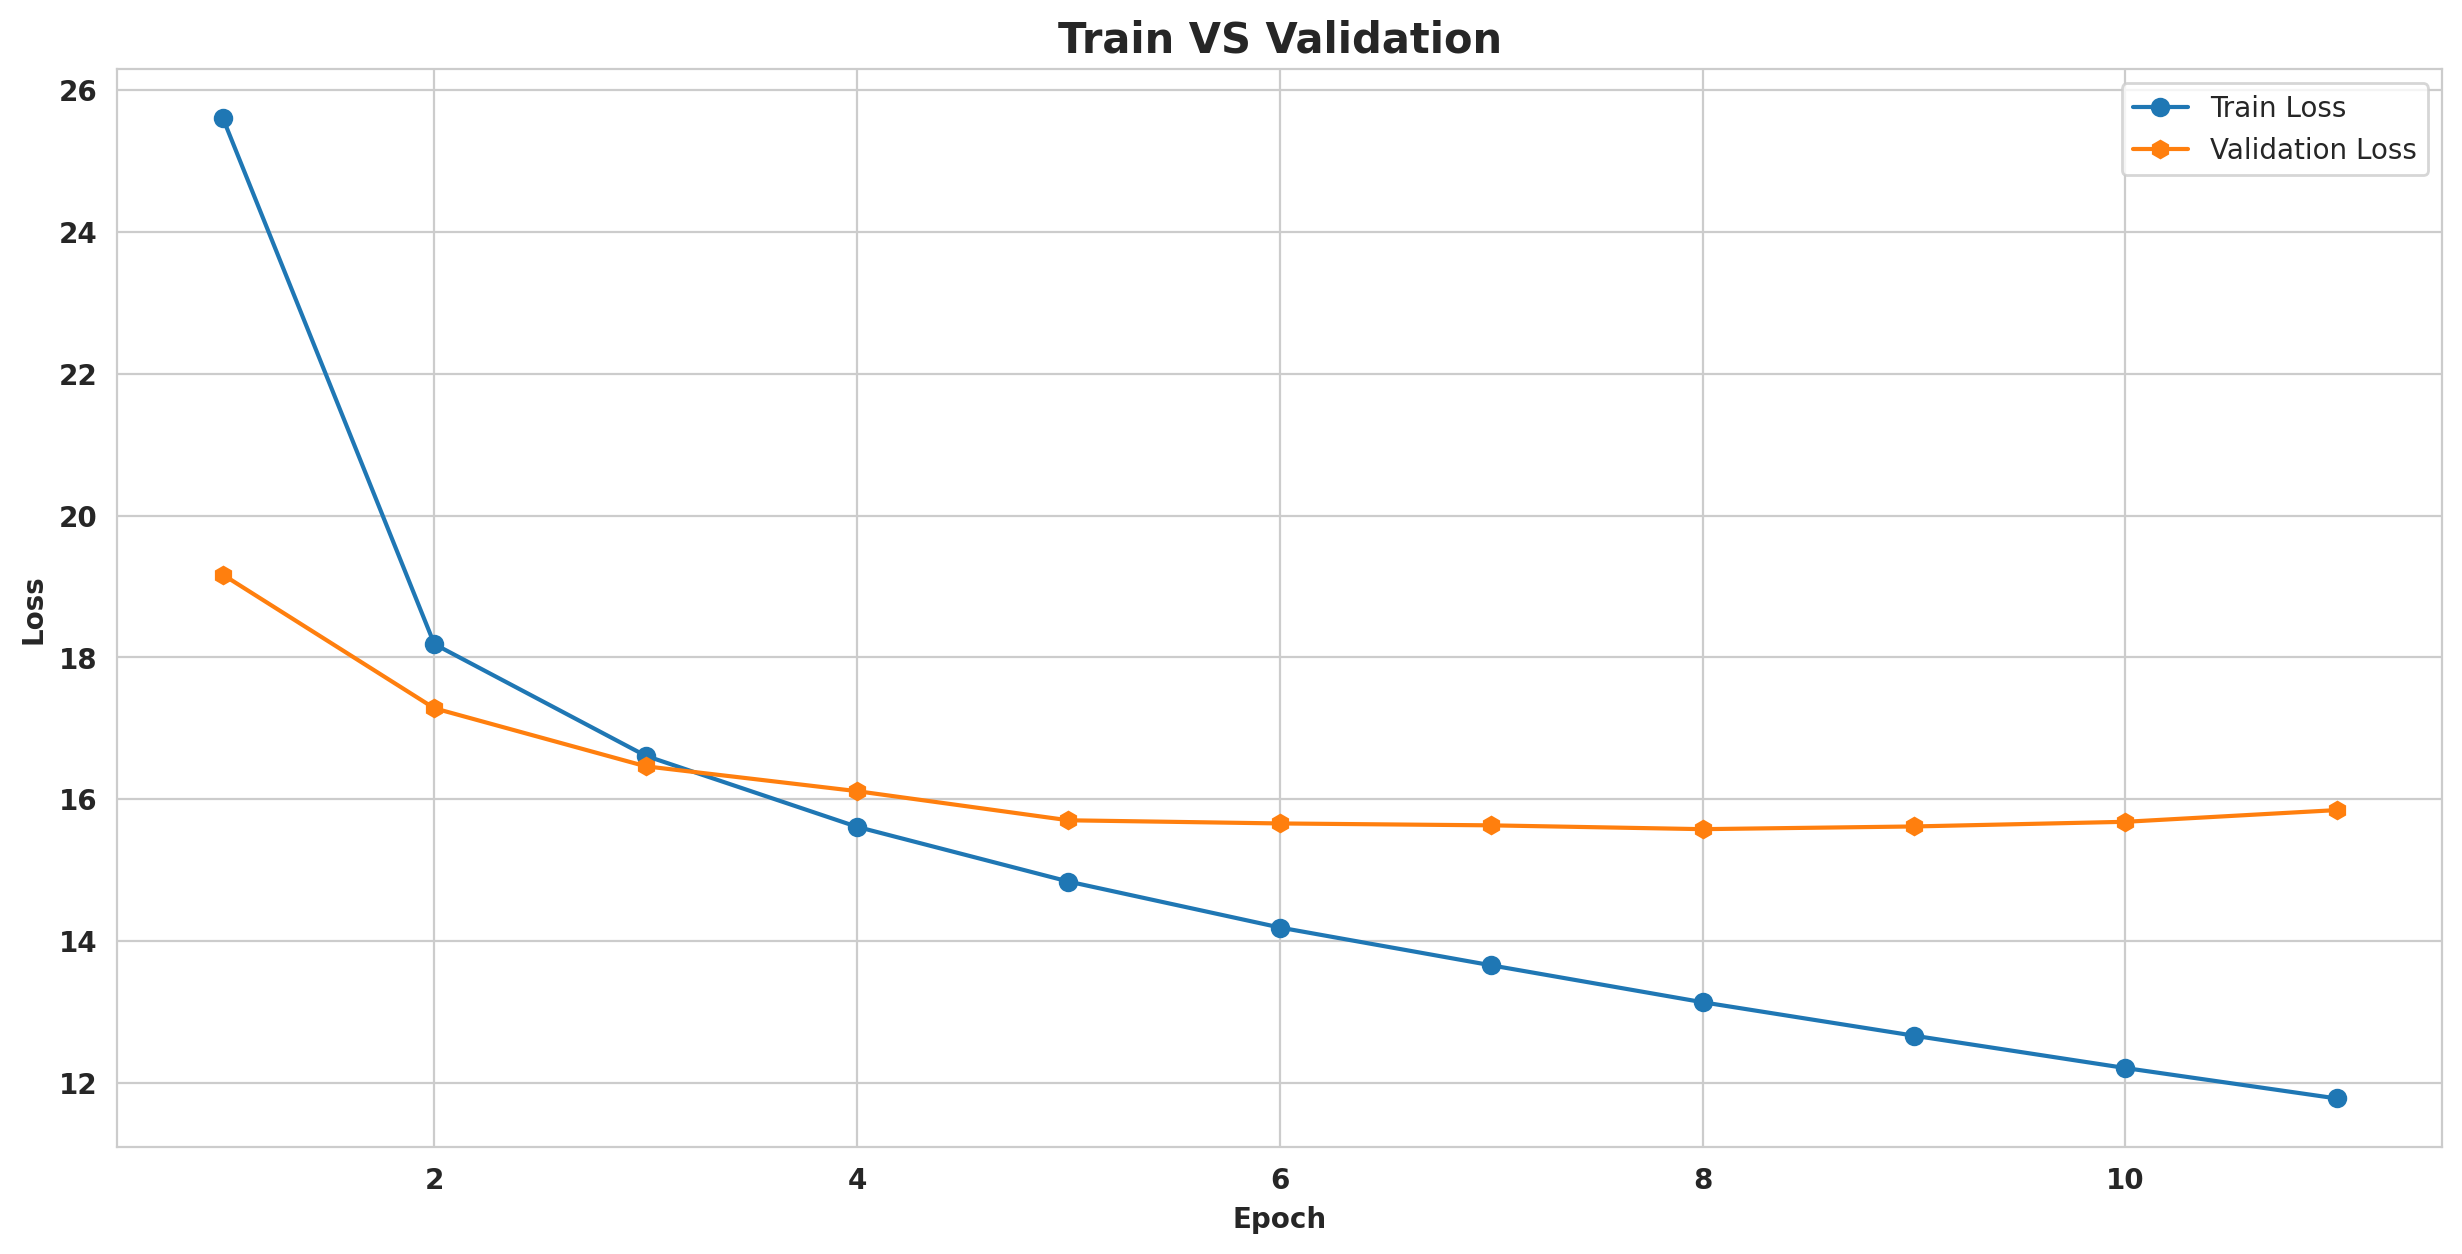

In [31]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [56]:
def decode_and_resize_mask2(mask_path_tensor, target_size):
    def load_npy_mask(mask_path):
    if isinstance(mask_path, np.ndarray):
        mask_path = mask_path.item()  # Extract from 0-dim array
    if isinstance(mask_path, bytes):
        mask_path = mask_path.decode("utf-8")
    data = np.load(mask_path, allow_pickle=True).item()
    masks = data['masks']  # Shape: (3, H, W)
    combined = np.sum(masks, axis=0, keepdims=True)  # Shape: (1, H, W)
    return combined.astype(np.float32)


MASK_DIR = "/kaggle/input/sam-feat/sam_features_f"
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1

def greedy_algorithm(img_path):
    # 1. Load image and mask
    image = decode_and_resize_img(img_path)
    filename = tf.strings.regex_replace(tf.strings.split(img_path, '/')[-1], '\\.jpg$', '')
    mask_path = tf.strings.join([MASK_DIR, "/", filename, ".npy"])
    mask = decode_and_resize_mask2(mask_path, FEATURE_MAP_SIZE)

    # 2. Expand dims
    image = tf.expand_dims(image, 0)  # (1, 299, 299, 3)
    mask = tf.expand_dims(mask, 0)    # (1, 10, 10, 1)

    # 3. Pass through CNN
    features = caption_model.cnn_model(image)  # (1, 10, 10, C)

    # 4. Reshape and apply mask
    B, H, W, C = features.shape
    reshaped_features = tf.reshape(features, (B, H * W, C))
    reshaped_mask = tf.reshape(mask, (B, H * W, 1))
    masked_features = reshaped_features * reshaped_mask  # Element-wise

    # 5. Encode
    encoded_img = caption_model.encoder(masked_features, training=False)

    # 6. Start decoding
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask_seq = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask_seq
        )

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    # 7. Clean up and return
    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption


In [57]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/77 [00:00<?, ?it/s]

In [73]:
# Calculates BLEU score of predictions
def BLEU_score(actual, predicted):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)
    # print(processed_actual,'\n',predicted)
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1=corpus_bleu(processed_actual, [predicted[0] for _ in range(5)], weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(processed_actual, [predicted[0] for _ in range(5)], weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(processed_actual, [predicted[0] for _ in range(5)], weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(processed_actual, [predicted[0] for _ in range(5)], weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}'),
    ]

### Visualizing some of the **test images** along with their corresponding **generated captions**

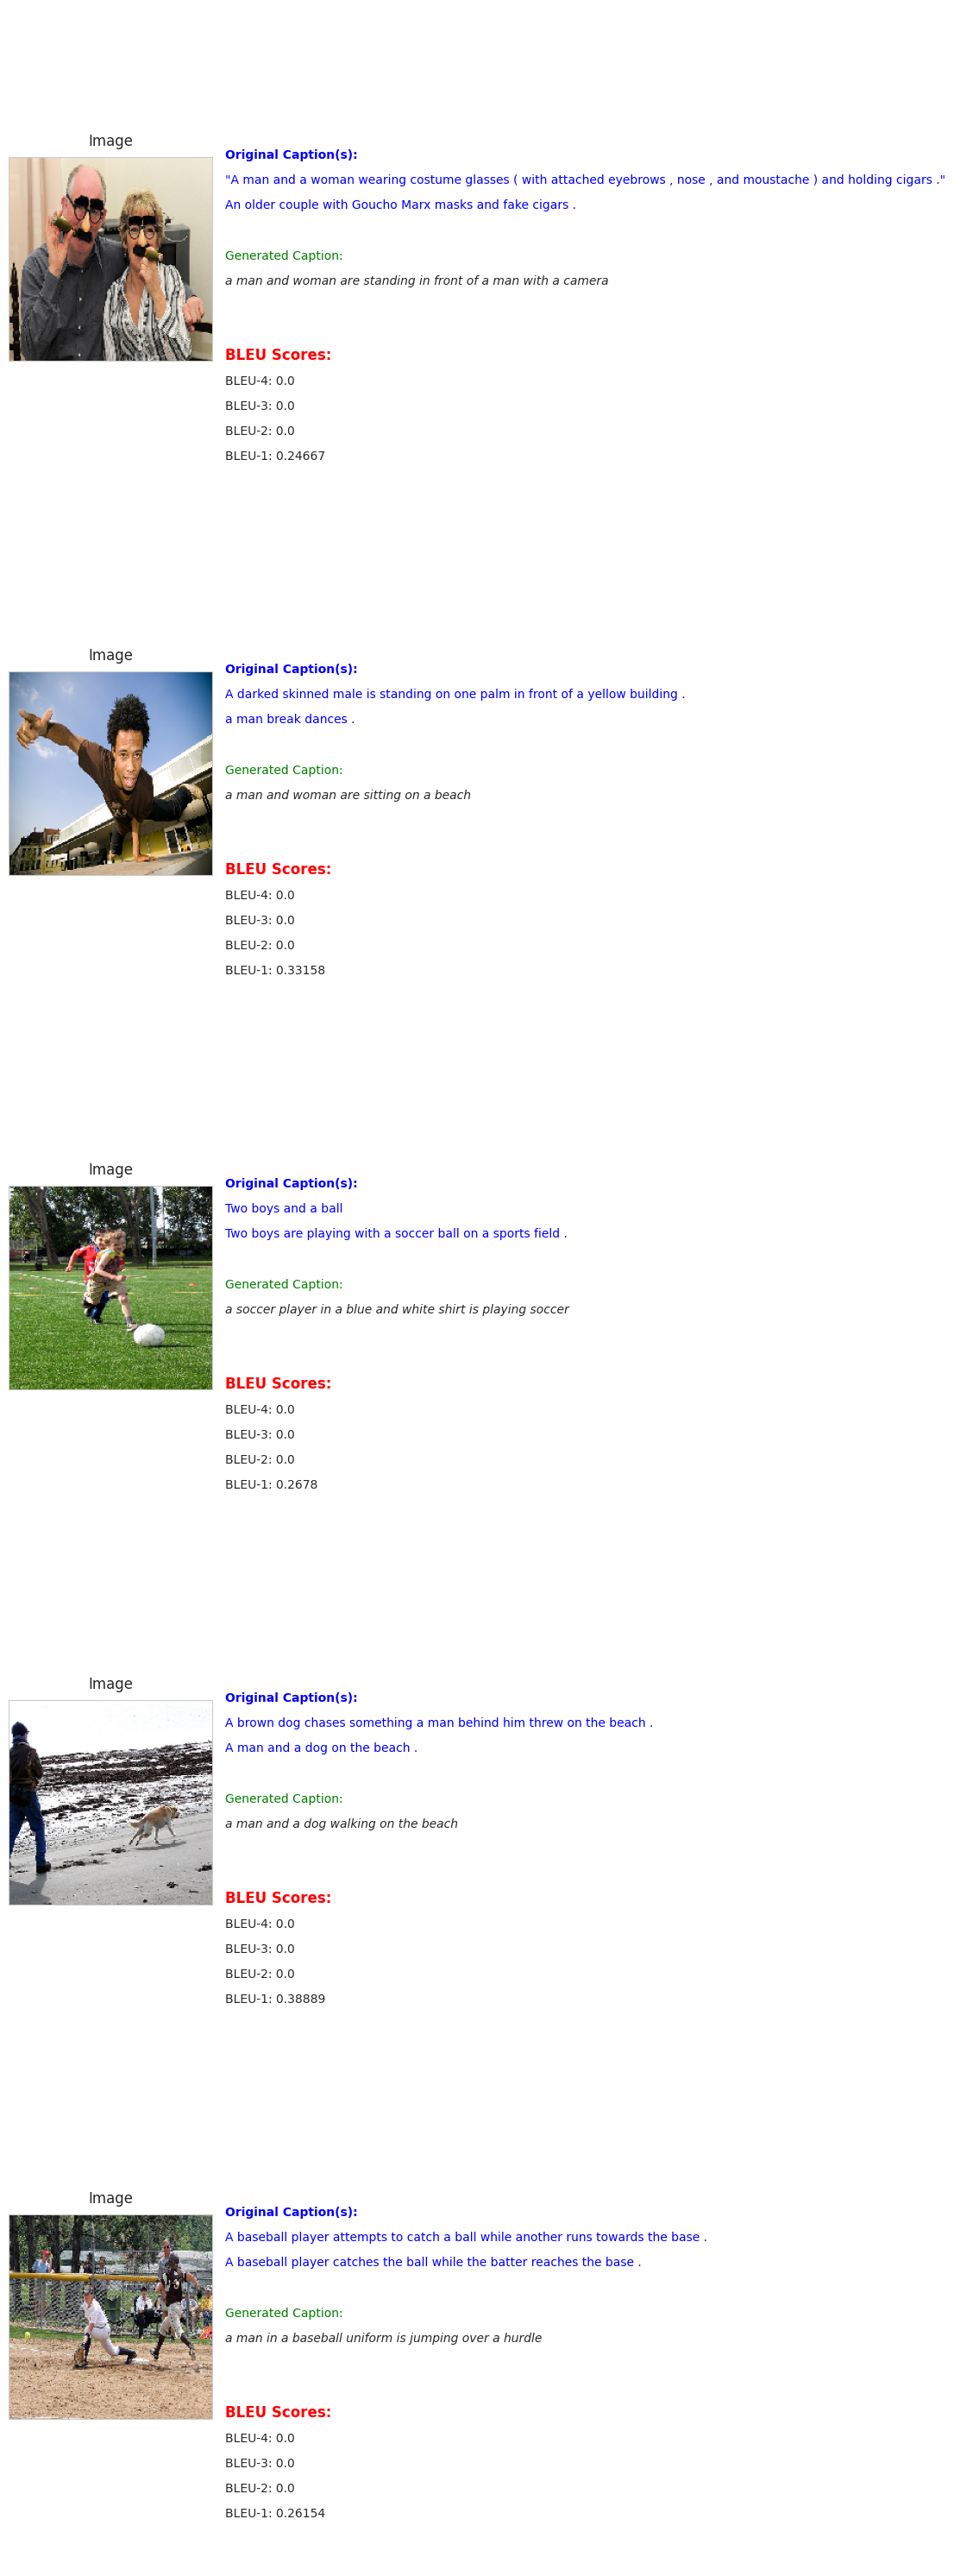

In [79]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys())  # List of all test images
    images = [np.random.choice(keys) for _ in range(num_of_images)]  # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(10, 6 * num_of_images))  # Larger figure for better readability
    
    for filename in images:
        # --- Load Image ---
        image_load = load_img(filename, target_size=(199, 199, 3))
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        ax.set_title("Image", fontsize=12, pad=10)
        count += 1

        # --- Prepare Captions and Scores ---
        actual_captions = data[filename]
        # Remove <start> and <end> tokens
        actual_captions = [cap.replace("<start> ", "").replace(" <end>", "").strip() 
                          for cap in actual_captions]
        
        generated_caption = generated_captions[filename]
        bleu_scores = evaluator(actual_captions, [generated_caption] * len(actual_captions))
        
        # --- Display Captions and Scores ---
        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        
        # Display original captions
        ax.text(0, 0.7, "Original Caption(s):", fontsize=10, color='blue', fontweight='bold')
        for i, cap in enumerate(actual_captions[:2]):  # Display first 2 actual captions (if more)
            ax.text(0, 0.65 - (i * 0.05), cap, fontsize=10, color='blue')
        
        # Display generated caption
        ax.text(0, 0.5, "Generated Caption:", fontsize=10, color='green')
        ax.text(0, 0.45, generated_caption, fontsize=10, style='italic')
        
        # Display BLEU scores
        ax.text(0, 0.3, "BLEU Scores:", fontsize=12, fontweight='bold', color='red')
        for i, score in enumerate(bleu_scores[:4]):  # Only show BLEU-1 to BLEU-4
            ax.text(0, 0.25 - (i * 0.05), score, fontsize=10)
        
        count += 1
    
    plt.tight_layout()
    plt.show()

# Example usage
visualization(test_data, generated_captions, BLEU_score, 5)

In [75]:
def calculate_avg_bleu_scores(test_data, generated_captions):
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []
    
    for image_id in test_data:
        # Get actual captions and remove <start> and <end> tokens
        actual_captions = test_data[image_id]
        actual_captions = [caption.replace("<start> ", "").replace(" <end>", "").strip() 
                          for caption in actual_captions]
        
        # Get generated caption for this image
        predicted_caption = generated_captions[image_id]
        
        # Process actual captions for vectorization (if needed)
        processed_actual = []
        for caption in actual_captions:
            # Standardize the caption (optional, depends on your BLEU_score function)
            cap = [INDEX_TO_WORD[x] for x in vectorization(caption).numpy() if INDEX_TO_WORD[x] != '']
            cap = ' '.join(cap)
            processed_actual.append(cap)
        
        # Calculate BLEU scores (using your existing BLEU_score function)
        bleu_scores = BLEU_score(processed_actual, [predicted_caption] * len(processed_actual))
        
        # Extract numerical scores from the BLEU_score output, BLEU-1: 0.12345 → 0.12345
        bleu1 = float(bleu_scores[0].split(': ')[1])  
        bleu2 = float(bleu_scores[1].split(': ')[1])  
        bleu3 = float(bleu_scores[2].split(': ')[1])
        bleu4 = float(bleu_scores[3].split(': ')[1])
        
        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)
    
    # Calculate averages
    avg_bleu1 = np.mean(bleu1_scores)
    avg_bleu2 = np.mean(bleu2_scores)
    avg_bleu3 = np.mean(bleu3_scores)
    avg_bleu4 = np.mean(bleu4_scores)
    
    return {
        'BLEU-1': avg_bleu1,
        'BLEU-2': avg_bleu2,
        'BLEU-3': avg_bleu3,
        'BLEU-4': avg_bleu4
    }

# Calculate average BLEU scores
avg_bleu_scores = calculate_avg_bleu_scores(test_data, generated_captions)

# Print the results
print("\nAverage BLEU Scores for Test Data:")
for key, value in avg_bleu_scores.items():
    print(f"{key}: {value:.4f}")


Average BLEU Scores for Test Data:
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.3367
